In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark

# Import necessary libraries and start Spark session
from pyspark import SparkContext, SparkConf
from google.colab import drive

# Set up SparkContext
conf = SparkConf().setAppName("Word Count").setMaster("local[*]")
sc = SparkContext(conf=conf)

# Mount Google Drive to access your files
drive.mount('/content/drive')


Mounted at /content/drive


k=2, Silhouette Score=0.7627796368306433
k=3, Silhouette Score=0.765292425142316
k=4, Silhouette Score=0.7237077346121722
k=5, Silhouette Score=0.6309494595675451
k=6, Silhouette Score=0.691517317732807
k=7, Silhouette Score=0.6656539052172794
k=8, Silhouette Score=0.6866252002742963
k=9, Silhouette Score=0.6784043611218532
k=10, Silhouette Score=0.6582652625846179


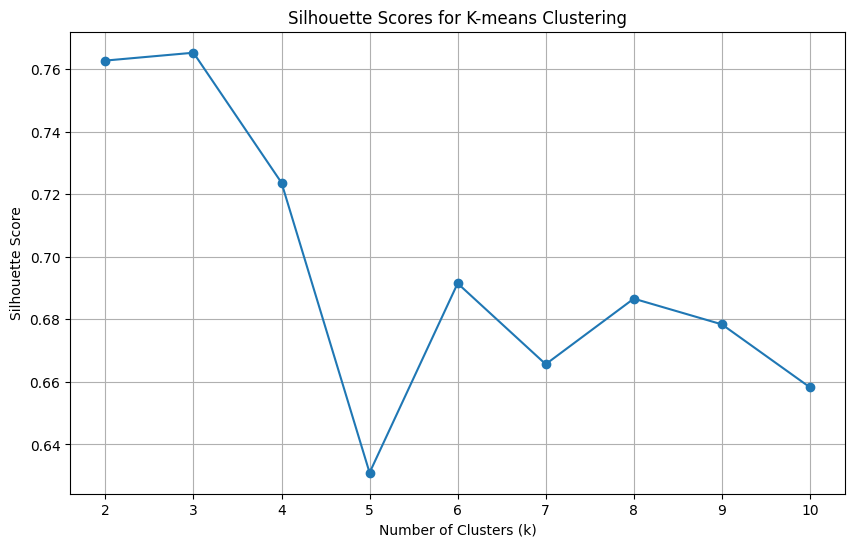

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("KMeansHousing").getOrCreate()

# Load the Housing dataset
data = spark.read.csv("/content/drive/MyDrive/Housing.csv", header=True, inferSchema=True)

# Drop categorical features
categorical_columns = [
    "mainroad", "guestroom", "basement", "hotwaterheating",
    "airconditioning", "prefarea", "furnishingstatus"
]
data = data.drop(*categorical_columns)

# Assemble numeric features into a feature vector
assembler = VectorAssembler(inputCols=data.columns, outputCol="features")
data = assembler.transform(data).select("features")

# Initialize variables for silhouette scores
silhouette_scores = []
k_values = range(2, 11)

# Loop through different k values
for k in k_values:
    # Train K-means model
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(data)

    # Make predictions
    predictions = model.transform(data)

    # Evaluate clustering by Silhouette score
    evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"k={k}, Silhouette Score={silhouette}")

# Plot Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.title("Silhouette Scores for K-means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Stop the Spark session
spark.stop()


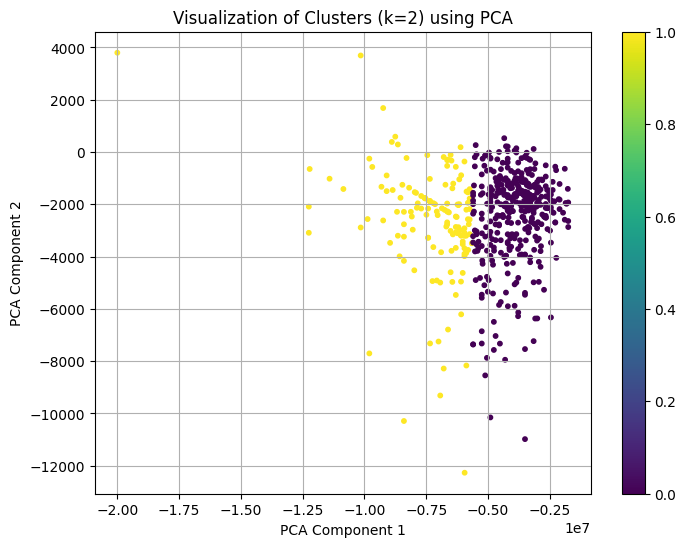

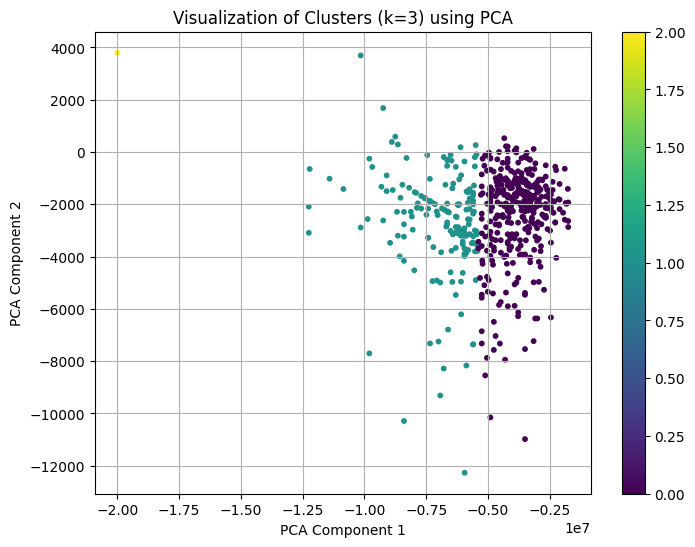

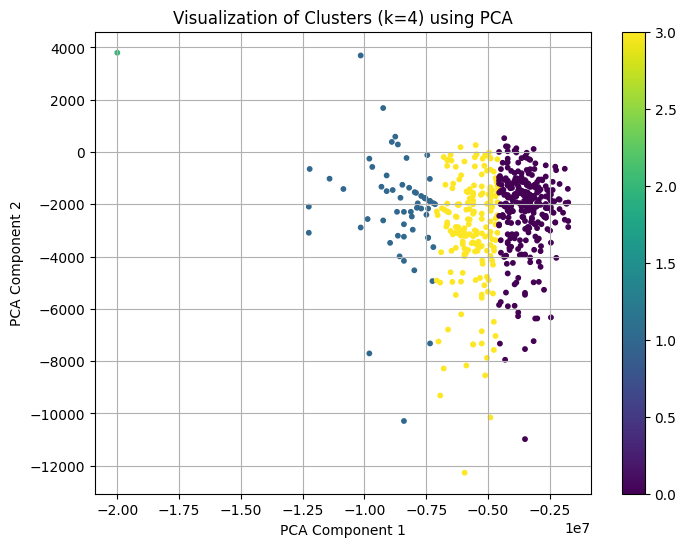

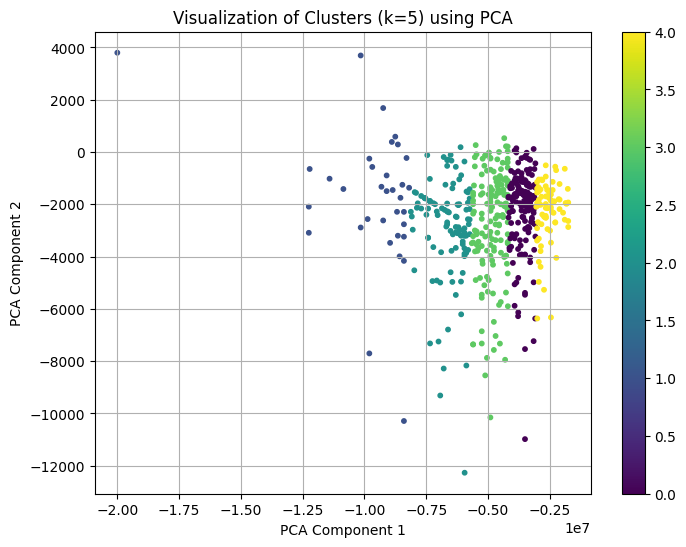

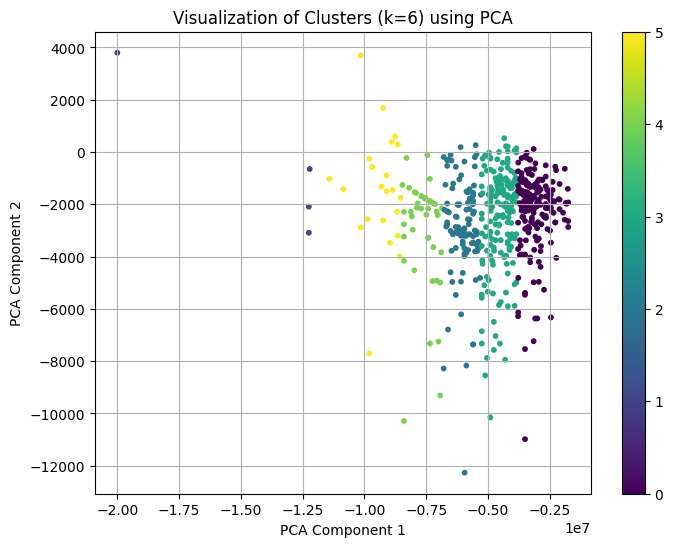

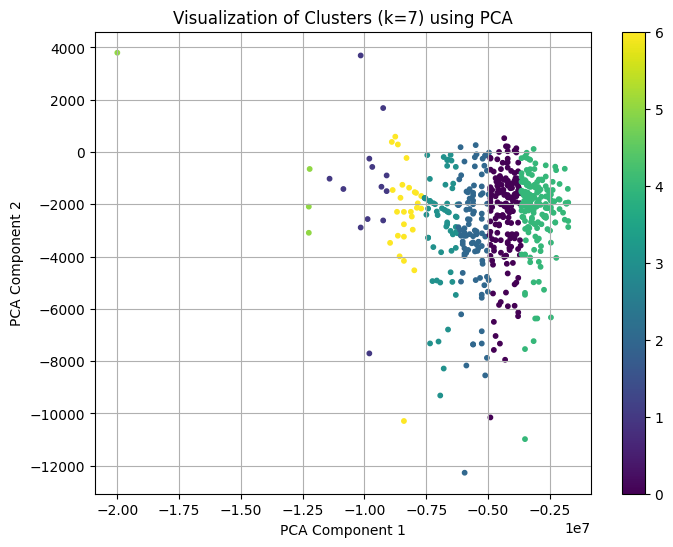

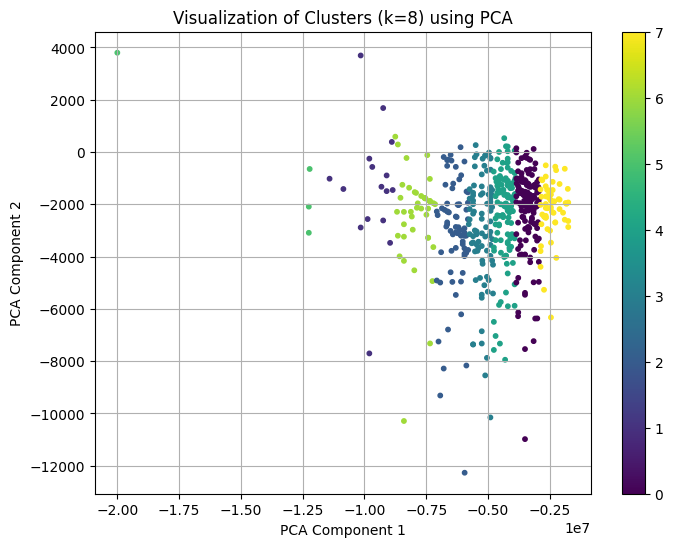

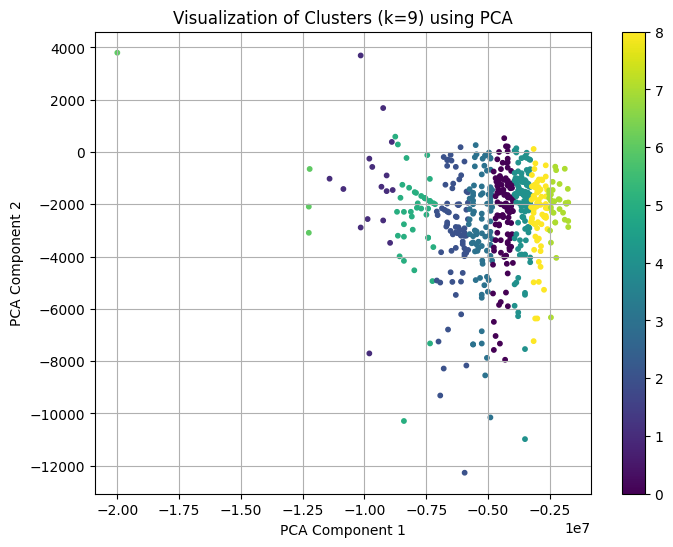

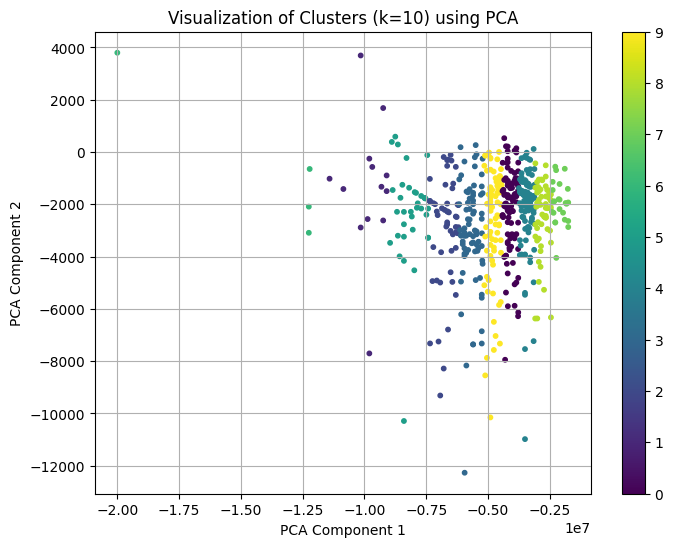

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("KMeansPCA").getOrCreate()

# Load the Housing dataset
data = spark.read.csv("/content/drive/MyDrive/Housing.csv", header=True, inferSchema=True)

# Drop categorical features
categorical_columns = [
    "mainroad", "guestroom", "basement", "hotwaterheating",
    "airconditioning", "prefarea", "furnishingstatus"
]
data = data.drop(*categorical_columns)

# Assemble numeric features into a feature vector
assembler = VectorAssembler(inputCols=data.columns, outputCol="features")
data = assembler.transform(data).select("features")

# Initialize variables for visualization
k_values = range(2, 11)
cluster_results = []

# Loop through different k values
for k in k_values:
    # Train K-means model
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(data)

    # Add cluster assignments to the data
    predictions = model.transform(data).withColumnRenamed("prediction", f"cluster_k{k}")

    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(k=2, inputCol="features", outputCol="pca_features")
    pca_model = pca.fit(predictions)
    pca_result = pca_model.transform(predictions)

    # Collect PCA results and cluster labels
    cluster_results.append((k, pca_result.select("pca_features", f"cluster_k{k}").collect()))

# Visualize clusters using PCA
for k, results in cluster_results:
    pca_points = [row["pca_features"] for row in results]
    cluster_labels = [row[f"cluster_k{k}"] for row in results]

    # Extract PCA coordinates
    x_coords = [p[0] for p in pca_points]
    y_coords = [p[1] for p in pca_points]

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_coords, y_coords, c=cluster_labels, cmap="viridis", s=10)
    plt.colorbar(scatter)
    plt.title(f"Visualization of Clusters (k={k}) using PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

# Stop the Spark session
spark.stop()


k=2, WSSSE=797937170052899.6
k=3, WSSSE=628006972545722.9
k=4, WSSSE=326670961001379.94
k=5, WSSSE=260229028032785.62
k=6, WSSSE=168013527749479.53
k=7, WSSSE=142681831987340.84
k=8, WSSSE=104220412455919.8
k=9, WSSSE=94822430241768.38
k=10, WSSSE=86240991754799.75


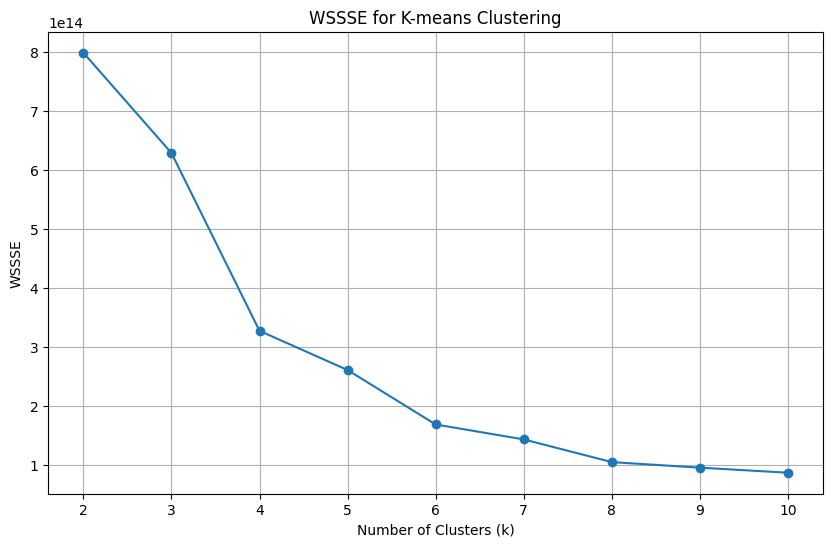

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np

# Initialize Spark session
spark = SparkSession.builder.appName("KMeansWSSSE").getOrCreate()

# Load the Housing dataset
data = spark.read.csv("/content/drive/MyDrive/Housing.csv", header=True, inferSchema=True)

# Drop categorical features
categorical_columns = [
    "mainroad", "guestroom", "basement", "hotwaterheating",
    "airconditioning", "prefarea", "furnishingstatus"
]
data = data.drop(*categorical_columns)

# Assemble numeric features into a feature vector
assembler = VectorAssembler(inputCols=data.columns, outputCol="features")
data = assembler.transform(data).select("features")

# Define a UDF to compute squared distances
def squared_distance_udf(features, cluster_index, centers):
    center = np.array(centers[cluster_index])
    point = np.array(features)
    return float(np.sum((point - center) ** 2))

# Initialize variables for WSSSE
k_values = range(2, 11)
wssse_values = []

# Loop through different k values
for k in k_values:
    # Train K-means model
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(data)

    # Get cluster centers
    centers = model.clusterCenters()

    # Broadcast cluster centers to executors
    centers_broadcast = spark.sparkContext.broadcast(centers)

    # Define the UDF for computing squared distances
    compute_distance = udf(
        lambda features, cluster_index: squared_distance_udf(features, cluster_index, centers_broadcast.value),
        DoubleType()
    )

    # Add squared distances to the dataset
    predictions = model.transform(data)
    predictions = predictions.withColumn(
        "squared_distance",
        compute_distance(col("features"), col("prediction"))
    )

    # Sum all squared distances for WSSSE
    wssse = predictions.select("squared_distance").rdd.map(lambda row: row[0]).sum()
    wssse_values.append(wssse)
    print(f"k={k}, WSSSE={wssse}")

# Plot WSSSE values
plt.figure(figsize=(10, 6))
plt.plot(k_values, wssse_values, marker='o', linestyle='-')
plt.title("WSSSE for K-means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE")
plt.grid(True)
plt.show()

# Stop the Spark session
spark.stop()


In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("ALS_MSE").getOrCreate()

# Load ratings.dat
data = spark.read.text("/content/drive/MyDrive/ratings.dat")

# Parse the dataset (userId::movieId::rating::timestamp)
ratings = data.rdd.map(lambda line: line[0].split("::")).toDF(["userId", "movieId", "rating", "timestamp"])

# Convert columns to appropriate data types
ratings = ratings.withColumn("userId", col("userId").cast("int")) \
                 .withColumn("movieId", col("movieId").cast("int")) \
                 .withColumn("rating", col("rating").cast("float")) \
                 .drop("timestamp")  # Drop timestamp as it's not needed

# Split data into training (70%) and test (30%)
train_data, test_data = ratings.randomSplit([0.7, 0.3], seed=42)

# Build ALS model
als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"
)

# Train the model
model = als.fit(train_data)

# Predict ratings on the test set
predictions = model.transform(test_data)

# Evaluate the model using MSE
evaluator = RegressionEvaluator(
    metricName="mse",
    labelCol="rating",
    predictionCol="prediction"
)
mse = evaluator.evaluate(predictions)

# Report MSE
print(f"Mean Squared Error (MSE) = {mse}")

# Stop Spark session
spark.stop()


Mean Squared Error (MSE) = 0.7659624290332463
